# Tutorial 2: Nanostring Dataset

In this tutorial, we apply S3RL to analyze FOV 014 from the Nanostring CosMx Spatial Molecular Imaging (SMI) lung cancer dataset. This dataset consists of 20 FFPE (formalin-fixed, paraffin-embedded) tissue sections derived from non-small cell lung cancer (NSCLC) samples, with high-resolution spatial transcriptomics measurements and expert-labeled cell types.

We focus on FOV 014, a representative sample containing diverse cell populations including tumor, immune, stromal, and endothelial cells. Our goal is to enhance the spatial expression data using S3RL, allowing better separation of spatial domains and improved downstream cell-cell communication analysis.

The raw and processed data for the CosMx NSCLC dataset are publicly available at:
👉 https://nanostring.com/products/cosmx-spatial-molecular-imager/nsclc-ffpe-dataset/

S3RL integrates spatial coordinates, gene expression profiles, and histology-derived features through a unified graph-based framework with contrastive and hyperspherical representation learning. In this FOV, S3RL reveals sharper spatial expression boundaries and greater correspondence with known cell-type marker genes such as DCN, SRGN, EPCAM, SOX4.

**Prepare the data**

In [ ]:
# Import necessary libraries
import os
import cv2
from S3RL.process_data import process_data
import pandas as pd
import anndata
import numpy as np

# set the paths of the data and the parameters
path = '../Data'
dataset = 'Nanostring'
id = '014' 
path_semantic_fea = '../Img_encoder/models/'
pixel_size = 60 # the size of the patch
knn = 5 # the number of neighbors

# Read the data files
data = pd.read_csv(os.path.join(path, dataset, 'all_in_one.csv'))
# Get the gene names
gene_name = pd.read_csv(os.path.join(path, dataset, 'Lung9_Rep1_exprMat_file.csv')).columns[2:].to_list()
# Filter data for the specific sample ID, extracting gene expression, spatial location, and ground truth labels
gene_exp = data[data['fov'] == int(id)][gene_name].values
loc = data[data['fov'] == int(id)][['CenterX_local_px', 'CenterY_local_px']].values
ground_truth = data[data['fov'] == int(id)]['cell_type'].values

# Create an AnnData object to store gene expression, spatial information, and ground truth labels
adata = anndata.AnnData(X=gene_exp.astype('float32'), obsm={'spatial': loc}, obs={'Ground Truth': ground_truth})
adata.var_names = gene_name
# Read the image data for the given dataset and ID
image = cv2.imread(os.path.join(path, dataset, f'CellComposite/CellComposite_F{str(id).zfill(3)}.jpg'))
# Load the semantic feature of the image (optional)
semantic_fea = np.load(os.path.join(path_semantic_fea, dataset, id, 'img_emb.npy'))

# Process the data using the process_data function, including constructing the spatial graph, extracting the semantic edges, and normalizing the data
adata = process_data(adata, image, pixel=pixel_size, knn=knn, semantic_fea=semantic_fea)

**Train the model**

In [40]:
from S3RL.model import S3RL
import yaml
import torch
from sklearn.metrics import adjusted_rand_score

device = torch.device("cuda:0")
cfg_path = '../Best_cfg'
with open(os.path.join(cfg_path, dataset, id+'.yaml'), 'r') as f:
    cfg = yaml.safe_load(f)
C = adata.obs['Ground Truth'].nunique()

model = S3RL(adata, n_clu=C, device=device, **cfg)

adata = model.train()

ground_truth = adata.obs['Ground Truth'].astype('category').cat.codes.values
print('ARI is ', adjusted_rand_score(ground_truth, adata.obs['pred']))

Training the S3RL model:  33%|███▎      | 489/1500 [00:11<00:24, 41.51it/s]


Reached the tolerance, early stop training at epoch 489
ARI is  0.9070980078332327


**Visualize the results**

In [3]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from S3RL.tools import hungarian_match
import pandas as pd
import matplotlib.colors as mcolors


label_map = {'tumors': 'Tumors', 'fibroblast': 'Fibroblast', 'lymphocyte': 'Lymphocyte', 
             'Mcell': 'Myeloid', 'neutrophil': 'Neutrophil', 'endothelial': 'Endothelial', 'epithelial': 'Epithelial', 'mast': 'Mast'}

full_cmap = plt.get_cmap('magma')
colors = full_cmap(np.linspace(0.1, 1.0, 256))[::-1]
cmap = mcolors.LinearSegmentedColormap.from_list("RdPu_middle", colors)

label_pred = hungarian_match(ground_truth, adata.obs['pred'])
label_dict = dict(zip(ground_truth, adata.obs['Ground Truth'].values))

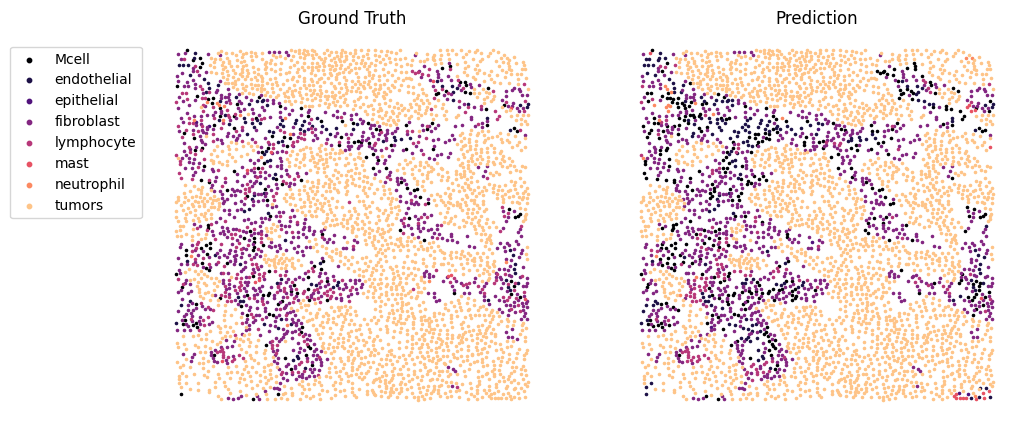

In [4]:
import matplotlib.pyplot as plt
import numpy as np

color_map = plt.get_cmap('magma')(np.linspace(0, 1, 9))
fig, ax = plt.subplots(1, 2, figsize=(11, 5))


for i in set(ground_truth):
    ax[0].scatter(loc[ground_truth == i, 1], loc[ground_truth == i, 0],
                color=color_map[i], s=2.5, label=label_dict[i], alpha=1.0)
ax[0].legend(loc='upper left', bbox_to_anchor=(-0.4, 0.98), fontsize=10, markerscale=2)
    
ax[0].set_xticks([])
ax[0].set_yticks([])
for spine in ax[0].spines.values():
    spine.set_visible(False)
    

for i in set(ground_truth):
    ax[1].scatter(loc[label_pred == i, 1], loc[label_pred == i, 0],
                color=color_map[i], s=2.5, label=label_dict[i], alpha=1.0)

ax[1].set_xticks([])
ax[1].set_yticks([])
for spine in ax[1].spines.values():
    spine.set_visible(False)
    
ax[0].set_title('Ground Truth', fontsize=12)
ax[1].set_title('Prediction', fontsize=12)
plt.show()

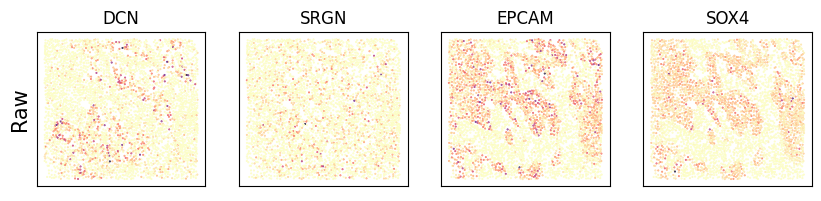

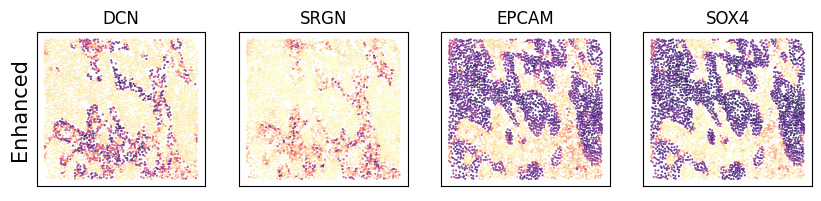

In [5]:
colors = plt.get_cmap('magma')(np.linspace(0.1, 1.0, 256))[::-1]
cmap = mcolors.LinearSegmentedColormap.from_list("RdPu_middle", colors)

gene_names = ['DCN','SRGN','EPCAM', 'SOX4']

fig, ax = plt.subplots(1, 4, figsize=(10, 2))
for i, gene_name in enumerate(gene_names):
    idx = adata.var_names.to_list().index(gene_name)
    ax[i].scatter(loc[:, 0], loc[:, 1], c=adata.X[:, idx], cmap=cmap, s=0.2)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title(gene_name)
ax[0].text(-0.1, 0.5, 'Raw', ha='center', va='center', fontsize=15, transform=ax[0].transAxes, rotation=90)

fig, ax = plt.subplots(1, 4, figsize=(10, 2))
for i, gene_name in enumerate(gene_names):
    idx = adata.var_names.to_list().index(gene_name)
    ax[i].scatter(loc[:, 0], loc[:, 1], c=adata.obsm['X_recon'][:, idx], cmap=cmap, s=0.2)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title(gene_name)
ax[1].text(-0.1, 0.5, 'Enhanced', ha='center', va='center', fontsize=15, transform=ax[0].transAxes, rotation=90)
plt.show()